In [1]:
import os
import sys
### Append the project root directory to sys.path
sys.path.append(os.path.abspath("/Users/prashal/dev/Face-Detector"))

from tensorflow.keras.optimizers import Adam
from math import ceil
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_DecodeDetections import DecodeDetections

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize

In [2]:
### Build the model and load trained weights into it

img_height = 512
img_width = 512
n_classes = 1

ssd = build_model(
    image_size=(img_height, img_width, 3),
    n_classes=n_classes,
    mode='training',
    l2_regularization=0.0005,
    min_scale=0.07,
    max_scale=0.9,
    aspect_ratios_global=[0.5, 1.0, 2.0],
    aspect_ratios_per_layer=None,
    two_boxes_for_ar1=True,
    steps=None,
    offsets=None,
    clip_boxes=False,
    variances=[1.0, 1.0, 1.0, 1.0],
    normalize_coords=True,
    subtract_mean=127.5,
    divide_by_stddev=127.5
)

weights_path = '../tmp/checkpoints/ssd7_epoch-13_loss-2.0928_val_loss-2.1003.keras'
ssd.load_weights(weights_path)

adam = Adam(learning_rate=0.001)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
ssd.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [3]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img_path = '../examples/researchers.jpg'
from imageio.v2 import imread
from tensorflow.keras.preprocessing import image

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [4]:
### Make predictions

y_pred = ssd.predict(input_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [5]:
### Decode the raw prediction `y_pred`

i = 0
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.1,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   233.1  100.18 286.78 175.68]
 [  1.     1.   112.68 107.65 169.34 180.91]
 [  1.     0.82 330.65 107.09 403.64 180.92]]


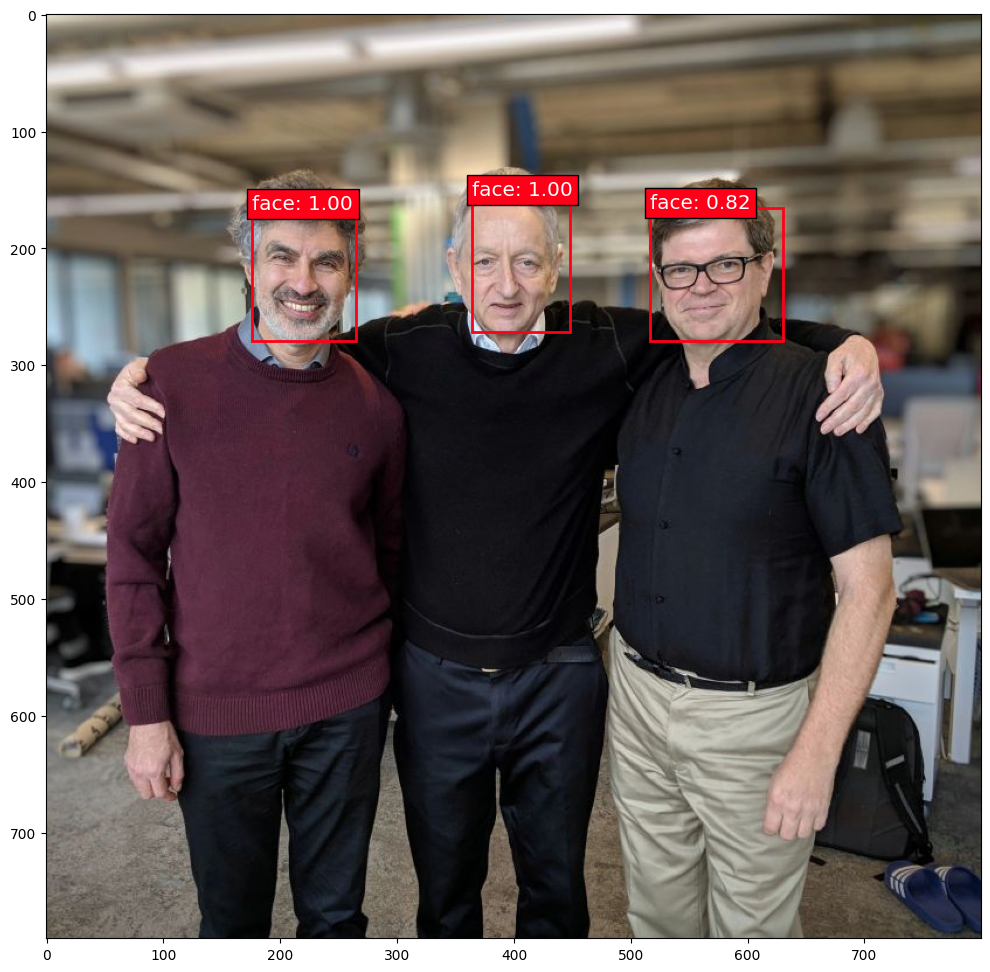

In [6]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'face']
plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[i]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})